In [1]:
%matplotlib inline
import shutil 
import os
from os.path import join, split, basename
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from glob import glob
from pylab import *

# Model 5 Version 2.3.2.1
## Isolating trials of learning -- all 21 together
### Removing last 3 volumes using FSL ROI

Subject WMAZE_001
Stimulus set1
Maximum Derivative
0.277
Mean
0.0432948717949
STD
0.0986618297031

Target Trial
25
Alternative Target Trial
25


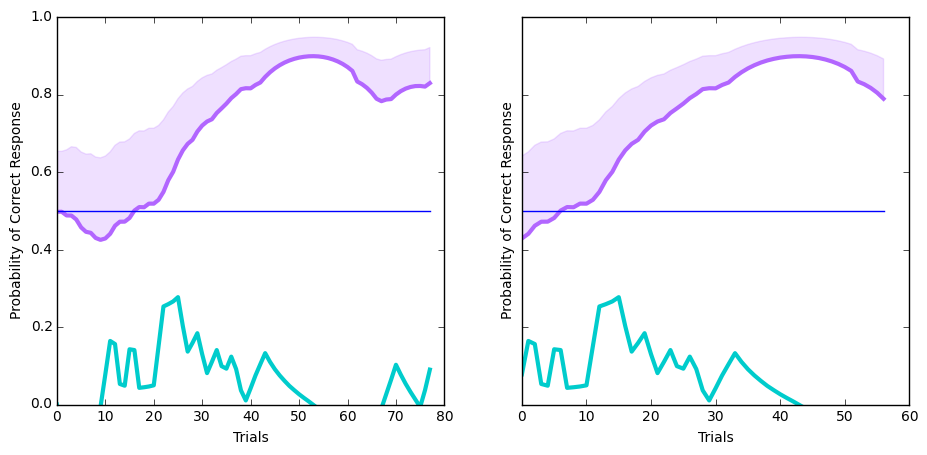

Subject WMAZE_001
Stimulus set2
Maximum Derivative
0.1715
Mean
0.0306392405063
STD
0.0673301866164

Target Trial
66
Alternative Target Trial
66


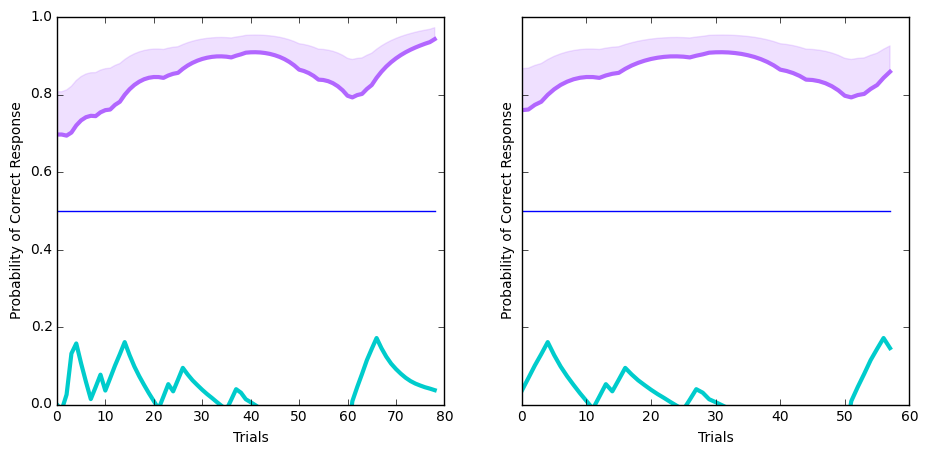

Subject WMAZE_001
Stimulus set3
Maximum Derivative
0.104
Mean
0.0123076923077
STD
0.0447012326143

Target Trial
24
Alternative Target Trial
24


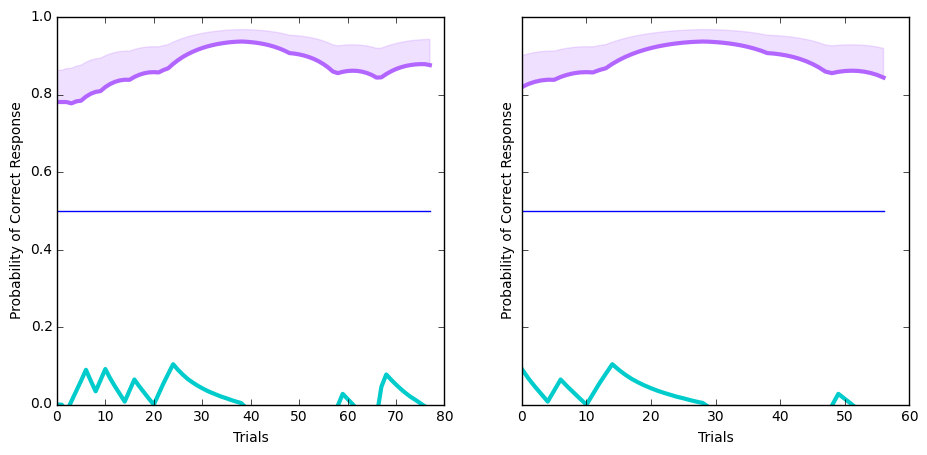

In [9]:
#cope01_FX_before_COND_incorr_run1_trl1_onset5.72.nii.gz
def onset_sort(x):
    x = x.split('_')[-1]
    return(x[5:-8])

subs = ['WMAZE_001']

#subs = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006',
#        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
#        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',
#        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']


sets = ['set1', 'set2', 'set3']
runs = ['run1', 'run2', 'run3', 'run4', 'run5', 'run6']


for sub in subs:
    sub_dir = '/home/data/madlab/data/mri/wmaze/'
    
    #grab the derivative files created from the set-based learning analysis
    frst_deriv_files = glob(join(sub_dir, 
                                 'scanner_behav/{0}/Bprime_pmode_set*.txt'.format(sub))) 
    frst_deriv_files.sort() 
    
    #grab the learning curve file for B trials
    learning_files = glob(join(sub_dir, 'scanner_behav/{0}/B_pmode_set*.txt'.format(sub))) 
    learning_files.sort()
    
    #grab the 95% confidence file for B trials
    upper_95_files = glob(join(sub_dir, 
                               'scanner_behav/{0}/B_p95_set*.txt'.format(sub)))
    upper_95_files.sort()
    
    #grab all cope files created by LSS Model 5
    cope_files = glob(join(sub_dir, 
                          'frstlvl/wmaze_MRthesis/fixed_before_condional/model5_2-3-2/{0}/'.format(sub),
                          'modelfit/contrasts/_estimate_model*/cope*_FX_before_COND_*corr_run*_trl*.nii.gz'))     
    cope_files.sort()
    
    #grab the behavioral files for all runs
    behav_runs = glob(join(sub_dir, 
                           'scanner_behav/{0}/{0}_wmazebl_2015*.txt'.format(sub))) 
    behav_runs.sort()
    
    
    
    #### LOADING AND ORGANIZING THE COPE FILES ####
    all_runs = []
    for curr_run in runs:
        #selects only the cope files containing the current run's number
        curr_run_files = np.array([f for f in cope_files if curr_run in f])
        #gets the onset time out of the file names
        onset_nums = [float(onset_sort(f)) for f in curr_run_files]
        sorted_nums = np.argsort(onset_nums)
        #arranges the actual files according to onset time
        curr_run_files = curr_run_files[sorted_nums]
        all_runs.append(curr_run_files)
        
    
    for i, curr_set in enumerate(sets):
        #load derivative, learning, and p95 files
        deriv_file = np.loadtxt(frst_deriv_files[i])
        learning_curve = np.loadtxt(learning_files[i]) 
        upper_95 = np.loadtxt(upper_95_files[i])
        
        #### COPE FILES ####
        #merge the two runs into one array for the current stim set
        curr_set_copes = np.concatenate((all_runs[i*2], all_runs[i*2+1]))
        #print len(curr_set_copes) 
        
        
        #### GETTING THE DERIV FILES TO MATCH NUMBER OF COPES ####
        #load behavioral files
        behav_run1 = pd.read_table(behav_runs[i*2])
        behav_run2 = pd.read_table(behav_runs[i*2+1])
        #info concerning onset time
        behav_os = np.empty(320, dtype=object)
        behav_os[:160] = behav_run1['StimOnset'].values
        behav_os[160:] = behav_run2['StimOnset'].values
        #info concerning subject response
        behav_resp = np.empty(320, dtype=object)
        behav_resp[:160] = behav_run1['Resp'].values
        behav_resp[160:] = behav_run2['Resp'].values
        #info concerning trial type
        behav_type = np.empty(320, dtype=object)
        behav_type[:160] = behav_run1['TrialType'].values
        behav_type[160:] = behav_run2['TrialType'].values       
        
        #indices of all Bs in the original dataset
        b_indices = np.where(behav_type == 'B')[0]       
        bad_Bs = []
                
        for curr_B in b_indices:
            #identify in B trials which are non-response
            if behav_resp[curr_B] == 'NR': 
                bad_Bs.append(curr_B)
            #indices for last 3 trials of each run or if B trial comes first (observed on 001 run 6)    
            if curr_B in [0, 157, 158, 159, 160, 317, 318, 319]: 
                bad_Bs.append(curr_B)
        bad_Bs.sort()       
        #get the indices for the bad Bs within the entire group of Bs
        bad_B_ind = [j for j, f in enumerate(b_indices) if f in bad_Bs] 
        bad_B_ind.sort()
        #reverse order of Bs to be removed
        bad_B_ind = bad_B_ind[::-1]
        
        #LEARNING CURVE FILES
        #create a temp version of learning_curve
        temp2 = list(learning_curve)
        #pop out the bad Bs starting from the end
        for curr_bad_B in bad_B_ind:
            temp2.pop(curr_bad_B)
        #save without the removed Bs    
        new_learning = np.array(temp2)
        alt_learning_curve = new_learning[10:-11]
        
        #P95 FILES
        #create a temp version of upper_95
        temp3 = list(upper_95)
        #pop out the bad Bs starting from the end
        for curr_bad_B in bad_B_ind:
            temp3.pop(curr_bad_B)
        #save without the removed Bs    
        new_upper_95 = np.array(temp3)
        alt_upper_95 = new_upper_95[10:-11]
        #print len(new_upper_95)

        #DERIV FILES
        #create a temp version of deriv_file
        temp = list(deriv_file)
        #pop out the bad Bs starting from the end
        for curr_bad_B in bad_B_ind:
            temp.pop(curr_bad_B)
        #save the deriv_file without the removed Bs    
        new_deriv = np.array(temp)
        alt_deriv_file = new_deriv[10:-11]
        target_trial = np.argmax(new_deriv)
        #grabs the index of the largest derivative
        alt_target_trial = np.argmax(alt_deriv_file)+10
        #print alt_target_trial
        #remove the bad Bs from the B-list       
        
        x = range(len(new_learning))
        x1 = range(len(alt_learning_curve))
        chance = np.ones(len(x)) * 0.5
        chance1 = np.ones(len(x1)) * 0.5
        

        fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize=(11, 5), sharex = False, sharey = True)  
        ax0.plot(x, new_learning, "#B266FF", linewidth = 3)
        ax0.plot(x, chance, 'b', linewidth = 1)
        ax0.fill_between(x, new_learning, new_upper_95, color = "#B266FF", alpha = 0.2)
        ax0.plot(x, new_deriv, "#00CCCC", linewidth = 3)
        ax0.set_ylim(0,1)
        ax0.set_xlabel('Trials')
        ax0.set_ylabel('Probability of Correct Response')
        
        ax1.plot(x1, alt_learning_curve, "#B266FF", linewidth = 3)
        ax1.plot(x1, chance1, 'b', linewidth = 1)
        ax1.fill_between(x1, alt_learning_curve, alt_upper_95, color = "#B266FF", alpha = 0.2)
        ax1.plot(x1, alt_deriv_file, "#00CCCC", linewidth = 3)
        
        ax1.set_ylim(0,1)
        ax1.set_xlabel('Trials')
        ax1.set_ylabel('Probability of Correct Response')
        
        print 'Subject ' + sub
        print 'Stimulus ' + curr_set
        print "Maximum Derivative"
        print max((new_deriv))
        print "Mean"
        print np.mean(new_deriv)
        print "STD"
        print np.std(new_deriv)
        print ""
        print 'Target Trial'
        print target_trial
        print 'Alternative Target Trial'
        print alt_target_trial
        plt.show()    